# **Importing Libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing ,csv file Input/Output
import keras
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import tqdm
import io
import os,glob
import ipywidgets as widgets
#from PIL import image
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras import datasets,layers,Sequential
from zipfile import ZipFile
from sklearn import preprocessing
from keras.layers import BatchNormalization
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

<ipython-input-1-8c4ab3b0bf28>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


# **Installing the libraries**

In [ ]:
!pip install tensorflow
!pip install keras

# **Loading Dataset**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 99% 15.0M/15.1M [00:00<00:00, 26.3MB/s]
100% 15.1M/15.1M [00:00<00:00, 16.0MB/s]


In [ ]:
file = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
x = []
y = []
labels = ['no','yes']
image_size = 224
for i in labels:
  folderPath = os.path.join('/content/brain_tumor_dataset',i)
  for j in os.listdir(folderPath):
    img_read = cv.imread(os.path.join(folderPath,j))
    img_read = cv.resize(img_read,(image_size,image_size))
    x.append(img_read)
    y.append(i)
x = np.array(x)
y = np.array(y)

In [ ]:
x,y = shuffle(x,y,random_state = 101 )

In [ ]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (253, 224, 224, 3)
Shape of Y: (253,)


In [ ]:
print(f"Shape of one example: {x[0].shape}")

Shape of one example: (224, 224, 3)


# **Showing Some Images**

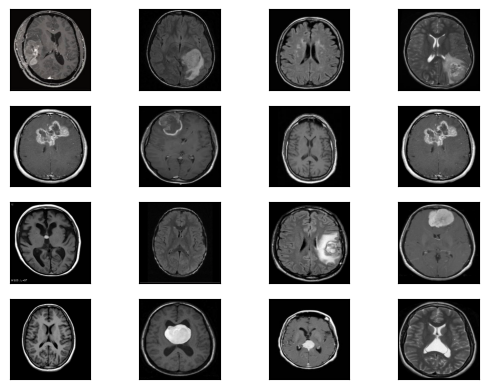

In [ ]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[i],cmap=plt.cm.binary)

# **Train Test Split**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [ ]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (202, 224, 224, 3)
Shape of x_test: (51, 224, 224, 3)
Shape of y_train: (202,)
Shape of y_test: (51,)


# **Label Encoding**

In [ ]:
#for train data
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
#for test data
y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# **Using VGG16**

In [ ]:
from keras.applications import vgg16

In [ ]:
r , c = 224 , 224
vgg = vgg16.VGG16(weights = 'imagenet', include_top = False,input_shape=(r,c,3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in vgg.layers: #no need to train pre-trained layers
  layer.trainable = False

In [ ]:
def vgg_model(bottom_model,claases):
  t_models = bottom_model.output
  t_models = GlobalAveragePooling2D()(t_models)
  t_models = Dense(1024,activation = 'relu')(t_models)
  t_models = Dense(512,activation = 'relu')(t_models)
  t_models = Dense(64,activation = 'relu')(t_models)
  t_models = Dense(32,activation = 'relu')(t_models)
  t_models = Dense(2,activation = 'softmax')(t_models)
  return t_models


# **Building the model**

In [ ]:
model_head = vgg_model(vgg,2)
model = Model(inputs = vgg.input,outputs = model_head)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Showing the shape of input and output**

In [ ]:
# Print the shapes of model input and output
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)

Input shape: (None, 224, 224, 3)
Output shape: (None, 2)


In [ ]:
# Print the shapes of x_train and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (202, 224, 224, 3)
y_train shape: (202, 2)


In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics = ['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Fitting the model**

In [ ]:
#model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),initial_epoch=0)
model.fit(x_train,y_train,epochs=25,validation_data=(x_test,y_test),initial_epoch=0)
#model.fit(x_train, y_train_onehot, epochs=25, validation_data=(x_test, y_test), initial_epoch=0)

Epoch 1/25
7/7 [==============================] - 176s 23s/step - loss: 0.5868 - accuracy: 0.6832 - val_loss: 0.5153 - val_accuracy: 0.7255
Epoch 2/25
7/7 [==============================] - 163s 24s/step - loss: 0.3633 - accuracy: 0.8614 - val_loss: 0.3648 - val_accuracy: 0.8235
Epoch 3/25
7/7 [==============================] - 164s 24s/step - loss: 0.2409 - accuracy: 0.9257 - val_loss: 0.3632 - val_accuracy: 0.8824
Epoch 4/25
7/7 [==============================] - 169s 25s/step - loss: 0.1658 - accuracy: 0.9406 - val_loss: 0.3089 - val_accuracy: 0.9020
Epoch 5/25
7/7 [==============================] - 162s 24s/step - loss: 0.1148 - accuracy: 0.9752 - val_loss: 0.3463 - val_accuracy: 0.8824
Epoch 6/25
7/7 [==============================] - 162s 24s/step - loss: 0.0831 - accuracy: 0.9802 - val_loss: 0.2993 - val_accuracy: 0.9020
Epoch 7/25
7/7 [==============================] - 161s 24s/step - loss: 0.0566 - accuracy: 1.0000 - val_loss: 0.3435 - val_accuracy: 0.8824
Epoch 8/25
7/7 [====

# **Seeing the Accuracy in Percentage**

In [ ]:
score = model.evaluate(x_test,y_test)

2/2 [==============================] - 30s 11s/step - loss: 0.3658 - accuracy: 0.9216


In [ ]:
print(f"Accuracy of the model to detect brain tumor is: {score[1]*100:0.2f}%")

Accuracy of the model to detect brain tumor is: 92.16%


# **Model Accuracy is 86.27%**

# **Making a Prediction**

In [ ]:
import random

In [ ]:
x.shape

(253, 224, 224, 3)

In [ ]:
y.shape

(253,)

In [ ]:
index = random.randrange(0,252,1)
print(f"The Random Index is: {index}")

The Random Index is: 134


Image at the index Number: 134: 


Text(0.5, 0, 'yes')

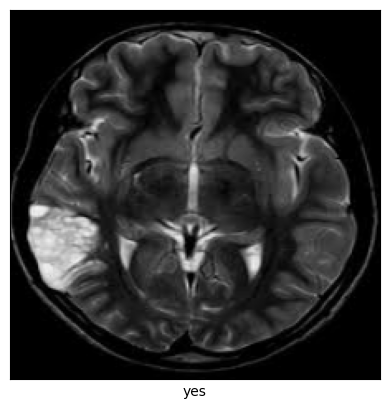

In [ ]:
print(f"Image at the index Number: {index}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index],cmap = plt.cm.binary)
plt.xlabel(y[index])

In [ ]:
x[index].shape

(224, 224, 3)

In [ ]:
x_new = x[index]
x_new =tf.expand_dims(x_new,axis = 0)

In [ ]:
pred = model.predict(x_new)

1/1 [==============================] - 1s 870ms/step


In [ ]:
pred

array([[0.00266411, 0.99733585]], dtype=float32)

In [ ]:
val = np.argmax(pred)

In [ ]:
print(f"The Prediction made is: {labels[val]}")

The Prediction made is: yes


# **Making Another Prediction**

In [ ]:
index2 = random.randrange(0,252,1)
print(f"The Random Index is: {index2}")

The Random Index is: 40


Image at the index Number: 40: 


Text(0.5, 0, 'no')

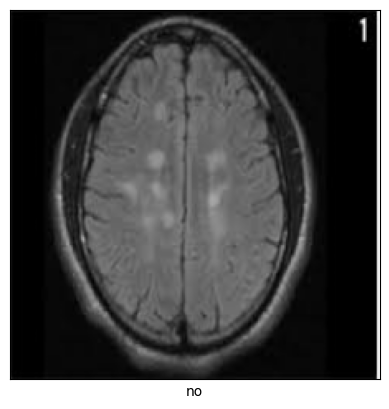

In [ ]:
print(f"Image at the index Number: {index2}: ")
plt.xticks([])
plt.yticks([])
plt.imshow(x[index2],cmap = plt.cm.binary)
plt.xlabel(y[index2])

In [ ]:
x[index2].shape

(224, 224, 3)

In [ ]:
x_new2 = x[index2]
x_new2 =tf.expand_dims(x_new2,axis = 0)

In [ ]:
pred2 = model.predict(x_new2)
val2 = np.argmax(pred2) # Get the index of the class with the highest probability

1/1 [==============================] - 1s 549ms/step


In [ ]:
print(f"The Prediction made is: {labels[val2]}")

The Prediction made is: no


# **Saving the Model**

In [ ]:
model.save('Brain_Tumor.h5')
from tensorflow.keras.models import load_model

loaded_model = load_model('Brain_Tumor.h5')

tf.saved_model.save(loaded_model,'Brain_Tumor_tf_2.16.1')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
! zip -r /content/Brain_Tumor_tf_2.16.1.zip /content/Brain_Tumor_tf_2.16.1

updating: content/Brain_Tumor_tf_2.16.1/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/assets/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/saved_model.pb (deflated 92%)
updating: content/Brain_Tumor_tf_2.16.1/fingerprint.pb (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/variables/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/Brain_Tumor_tf_2.16.1/variables/variables.index (deflated 80%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/ (stored 0%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/assets/ (stored 0%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/saved_model.pb (deflated 92%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/fingerprint.pb (stored 0%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/variables/ (stored 0%)
  adding: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/variables/variables.data-00

In [ ]:
from google.colab import files
files.download('/content/Brain_Tumor_tf_2.16.1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cd '/content/Brain_Tumor_tf_2.16.1'

/content/Brain_Tumor_tf_2.16.1


In [ ]:
!zip -r /content/Brain_Tumor_tf_2.16.1.zip /content/Brain_Tumor_tf_2.16.1

updating: content/Brain_Tumor_tf_2.16.1/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/assets/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/saved_model.pb (deflated 92%)
updating: content/Brain_Tumor_tf_2.16.1/fingerprint.pb (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/variables/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/Brain_Tumor_tf_2.16.1/variables/variables.index (deflated 80%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/assets/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/saved_model.pb (deflated 92%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/fingerprint.pb (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/variables/ (stored 0%)
updating: content/Brain_Tumor_tf_2.16.1/Brain_Tumor_tf_2.16.1/variables/variables.data-00

In [ ]:
from google.colab import files
files.download('/content/Brain_Tumor_tf_2.16.1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>